In [1]:
# This quickly generates a FlareLightCurve
from altaipony.tests.test_flarelc import mock_flc

#Alternatively, use
from altaipony.flarelc import FlareLightCurve

# We shall be testing our code
import pytest 

# The basis
import numpy as np
import pandas as pd

# For plotting diagnostics
import matplotlib.pyplot as plt
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

import matplotlib
matplotlib.rc('font', **font)

import seaborn as sns

# Import our main class
from qlearning.flarefairy import FlareFairy

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Set up a light curve

In [2]:
# Let's generate a flare light curve to work with

# small size to keep computational effort at bay
n = 200

# time, flux noise
time = np.linspace(20,22,n)
flux = 500. + 15.* np.sin(time*4) + 10 * np.random.rand(n)
flux_err = flux * .01

# a hand-crafted flare signal
flux[60] = 730
flux[61] = 600
flux[62] = 560
flux[63] = 530
flux[64] = 525
flux[65] = 520
flux[66] = 515
flux[67] = 510

# define FlareLightCurve object
flc = FlareLightCurve(time=time, flux=flux, flux_err=flux_err)

Text(0, 0.5, 'flux [arb. u.]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


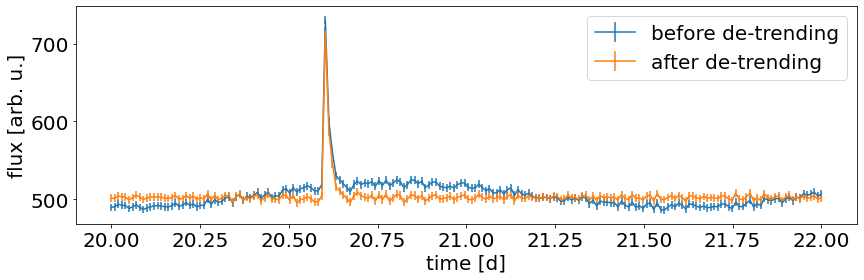

In [3]:
# get de-trended light curve (useful for later)
flcd = flc.detrend("savgol")

# look at the result
plt.figure(figsize=(14,4))
plt.errorbar(flcd.time, flcd.flux, yerr=flcd.flux_err, label="before de-trending");
plt.errorbar(flcd.time, flcd.detrended_flux, yerr=flcd.detrended_flux_err, label="after de-trending");
plt.legend()
plt.xlabel("time [d]")
plt.ylabel("flux [arb. u.]")

In [4]:
# Find the flare with AltaiPony
flare = flcd.find_flares().flares.iloc[0]
flare.dropna()

Found 1 candidate(s) in the (0,200) gap.


istart                              60
istop                               63
tstart                          20.603
tstop                          20.6332
ed_rec                         590.388
ed_rec_err                     13.0861
ampl_rec                      0.425818
dur                          0.0301508
total_n_valid_data_points          200
Name: 0, dtype: object

# Instantiate a fairy

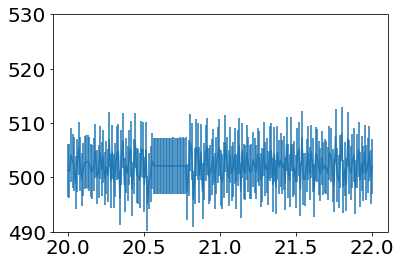

In [5]:

flcd.detrended_flux[56:78] = np.nanmedian(flcd.detrended_flux)
fairy = FlareFairy(flcd, flare, LEARNING_RATE=.6, DISCOUNT=.5,  amax=2., dmax=2.,)
plt.errorbar(flcd.time, flcd.detrended_flux, yerr=flcd.detrended_flux_err)
plt.ylim(490,530);

# Get a bunch of injection-recovery pairs for testing

In [6]:
%%capture
flcdc, fake_lc = flcd.sample_flare_recovery(inject_before_detrending=False, mode="savgol",
                                              iterations=100, fakefreq=1e-7, #show_progress=False,
                                              ampl=[fairy.goal[0]/4,fairy.goal[0]*4],
                                              dur=[fairy.goal[1]/6/4,fairy.goal[1]/6*2])


Found 0 candidate(s) in the (0,200) gap.
N/A%|                                                                         |Found 1 candidate(s) in the (0,200) gap.
Found 0 candidate(s) in the (0,200) gap.
  2%|#                                                                        |Found 0 candidate(s) in the (0,200) gap.
Found 0 candidate(s) in the (0,200) gap.
  4%|##                                                                       |Found 1 candidate(s) in the (0,200) gap.
Found 0 candidate(s) in the (0,200) gap.
  6%|####                                                                     |Found 1 candidate(s) in the (0,200) gap.
Found 1 candidate(s) in the (0,200) gap.
  8%|#####                                                                    |Found 0 candidate(s) in the (0,200) gap.
Found 1 candidate(s) in the (0,200) gap.
Found 1 candidate(s) in the (0,200) gap.
 11%|########                                                                 |Found 0 candidate(s) in the (0,200

<ErrorbarContainer object of 3 artists>

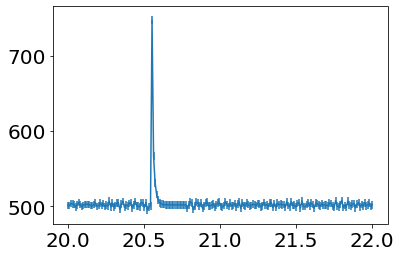

In [7]:
# A fake flare in the light curve example
plt.errorbar(fake_lc.time, fake_lc.detrended_flux, yerr=flcdc.detrended_flux_err)

In [8]:
# fake flare table
ff = flcdc.fake_flares
# This is the row in the fake flare table that corresponds to the plotted flare
fake_lc.flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,temp
0,55,59,NaN,NaN,20.552764,20.592965,609.252175,5.681026,0.487524,0.040201,200.0,1


# Now test reward function that you defined and make some plots

In [9]:
#import the reward functions we want to test
from qlearning.rewards import is_done, get_reward_gauss

In [10]:
# define some parameters
w = [fairy.astep*5., fairy.dstep*10]
w2 = [1., flare.ampl_rec / flare.dur / 2]

rew = []
for i, res in ff.iterrows():
    
    recovered = [res.ampl_rec, res.dur]
    rew.append(get_reward_gauss(flare, recovered, w, w2))

ff["reward"] = rew

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


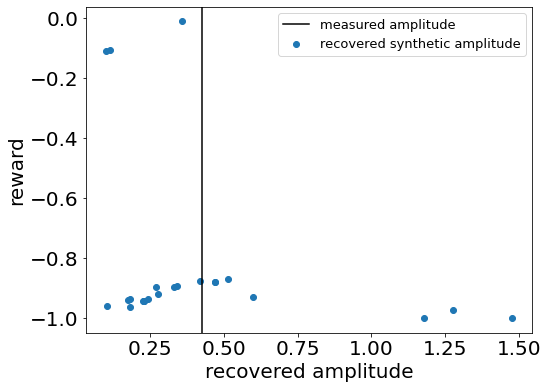

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(ff.ampl_rec, ff.reward, label="recovered synthetic amplitude")
plt.axvline(flare.ampl_rec, label="measured amplitude", c="k")
plt.xlabel("recovered amplitude")
plt.ylabel("reward")
plt.legend(loc=1,fontsize=13);

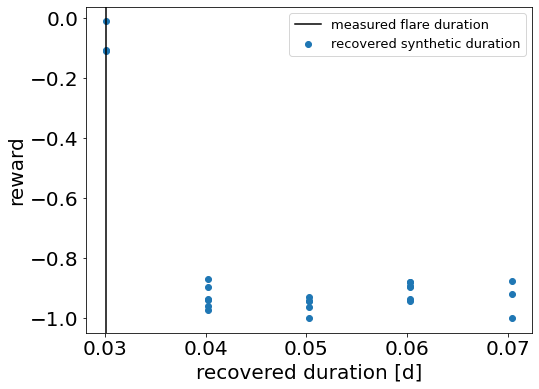

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(ff.dur, ff.reward, label="recovered synthetic duration")
plt.axvline(flare.dur, label="measured flare duration", c="k")
plt.xlabel("recovered duration [d]")
plt.ylabel("reward")
plt.legend(loc=1,fontsize=13, frameon=True);